In [1]:
!which python; python --version

/Users/swagatam/miniconda3/envs/vexl/bin/python
Python 3.8.18


## Provided functions

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


def cost_fn(w, x, y, lmbd):
    ''' L1 loss + L2 regularization

    w: weights to estimate d
    x: data points n x d
    y: true values n x 1
    lmbd: weight regularization

    output: loss ||x * w - y||_1 + lmbd * ||w||_2^2
    '''
    return np.abs(x @ np.expand_dims(w, 1) - y).sum() +\
           lmbd * (w ** 2).sum()

def L1LossRegression(X, Y, lmbd_reg=0.):
    ''' solves linear regression with
    L1 Loss + L2 regularization

    X: deisgn matrix n x d
    Y: true values n x 1
    lmbd_reg: weight regularization

    output: weight of linear regression d x 1
    '''
    w = minimize(cost_fn, np.zeros(X.shape[1]),
                 args=(X, Y, lmbd_reg)).x
    return np.expand_dims(w, 1)

## note: please grade exercise 1
### the answers to theoretical questions are in markdown cells

# Exercise 1 a.

In [2]:
def LeastSquares(Designmatrix, Y):
    ''' solves least squares linear regression.
    
    Designmatrix: feature matrix n x d
    Y: labels n x 1
    
    returns: learned weights w d x 1
    '''
    A = Designmatrix.T @ Designmatrix
    b = Y
    # solve for Ax=b
    w = np.linalg.solve(A, b)
    assert np.allclose(w, np.linalg.inv(A) @ b), "some error in equation solver"
    return w
    
def RidgeRegression(Designmatrix, Y, Lambda):
    ''' solves ridge regression (l2 regularization).
    
    Designmatrix: feature matrix n x d
    Y: labels n x 1
    
    returns: learned weights w d x 1
    '''
    A = Designmatrix.T @ Designmatrix
    LambdaId = Lambda * np.eye(Designmatrix.shape[1])
    
    # note that (A + LambdaId) is also symmetric pos def, so unique solution always exists as invertible
    w = np.linalg.solve(A + LambdaId, (Designmatrix.T@Y))
    assert np.allclose(w, np.linalg.inv(A + LambdaId) @ (Designmatrix.T@Y)), "some error in equation solver"
    return w

# Exercise 1 b. Basis function `Basis(X, k)`

In [3]:
def phi0(x):
    return np.ones_like(x)

def phi_2l_minus_1(x, l):
    return np.cos(2*np.pi*l*x)

def phi_2l(x, l):
    return np.sin(2*np.pi*l*x)

def Basis(X, k):
    ''' generate the design matrix using the orthogonal Fourier basis functions
    X: n x 1 feature vector
    k: maximal frequency
    
    output: Designmatrix of shape n x (2k+1)
    so each scalar observation is now a 2k+1 sized feature vector.
    '''
    # l runs from 1,2,...,k
    features = [phi0(X)]
    for l in range(1,k+1):
        features.append(phi_2l_minus_1(X, l))
        features.append(phi_2l(X, l))
    return np.column_stack(features)

# Exercise 1 c.

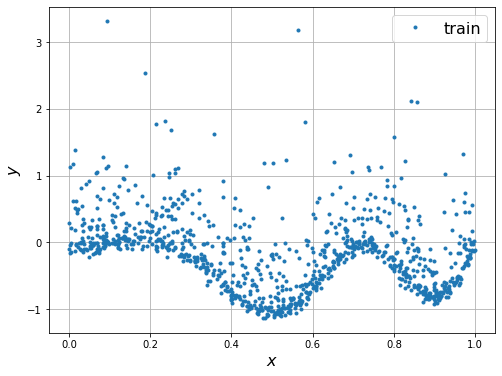

In [4]:
data = np.load('./onedim_data.npy', allow_pickle=True).item()
Xtrain, Ytrain, Xtest, Ytest = data['Xtrain'], data['Ytrain'], data['Xtest'], data['Ytest']


plt.figure(figsize=(8,6))
plt.plot(Xtrain, Ytrain, '.', label='train')
# plt.plot(Xtest, Ytest, 'x', alpha=0.4, label='test')
plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$y$', fontsize=16)
plt.grid()
plt.legend(fontsize=16)

plt.show()

In [5]:
# see the residual distribution
# plt.plot(Ytrain - Xtrain, '.')

## 1.c. part 1

Looking at the data above, I would use the $L_1$ loss function because:

- the noise is asymmetric and is mostly positive or above the mean of a non-linear function of $x$, i.e., the noise does not seem to be gaussian around the mean and hence violates the assumption for $L_2$ loss regression

- also looking at the data, there seem to be many outliers, and since $L_2$ loss penalizes outliers heavily (squared) than $L_1$ loss, choosing $L_1$ loss would make the fit less sensitive (more robust) to outliers.


So we will take "$L_1$ loss with $L_2$ regularizer" for this regression problem.

In [6]:
def L1loss(w, x, y, lmbd):
    # a function to compute the loss
    return np.abs(x@w - y).sum() + lmbd * (w**2).sum()

In [7]:
USE_LOSS = {
    "L1": L1LossRegression,
    "L2": RidgeRegression,
}

In [8]:
LOSSS = '$L_1$'

In [9]:
figdims = [8, 6]

## 1.c. experiment with `K` basis functions with 2 values of $\lambda$

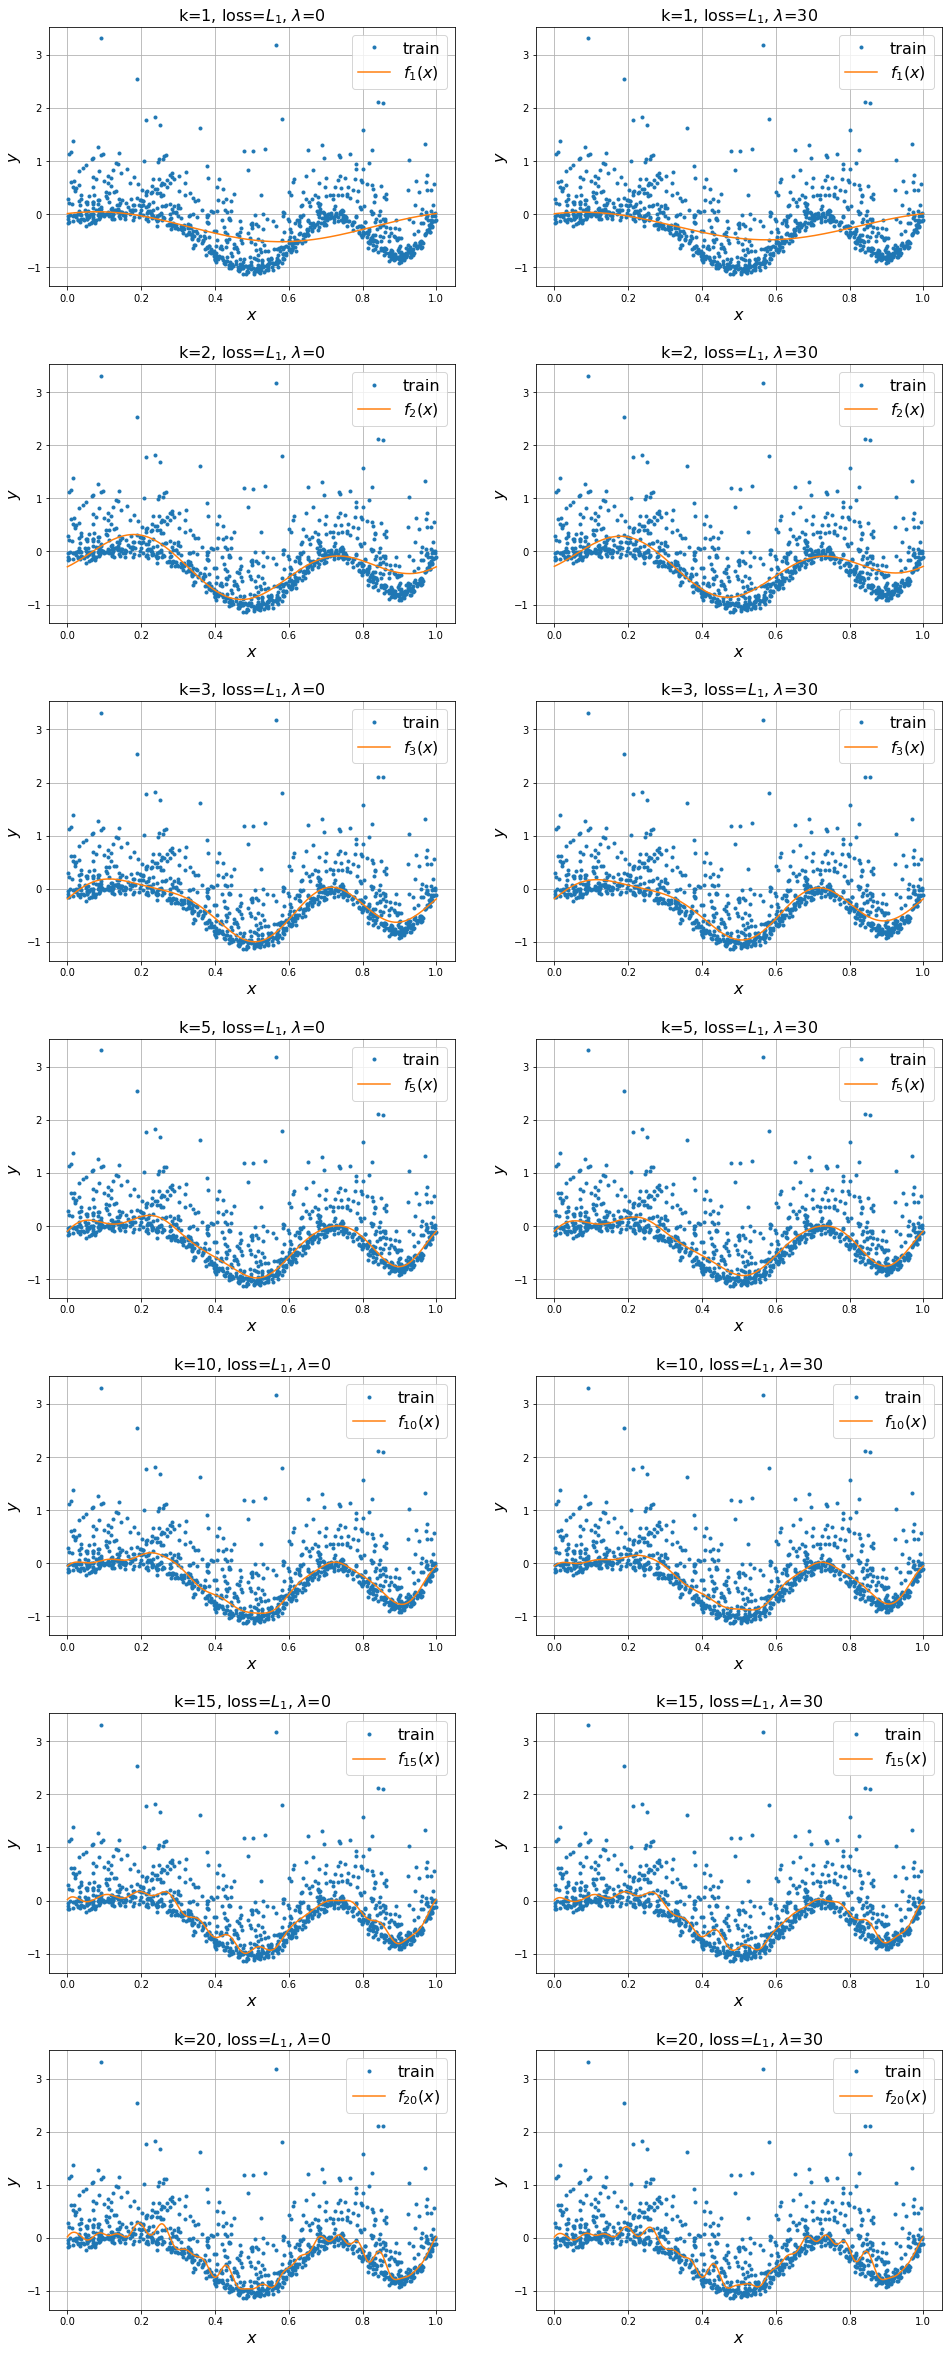

In [21]:
K = [1,2,3,5,10,15,20]
LAMBDA = [0, 30]#, 1000]

nrows = len(K)
ncols = len(LAMBDA)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=(figdims[0]*ncols, figdims[1]*nrows),
                         gridspec_kw={'wspace':0.2,'hspace':0.3})
train_losses = {}
test_losses = {}


for i, k in enumerate(K):
    train_losses[k] = {}
    test_losses[k] = {}
    for j, lmda in enumerate(LAMBDA):
        
        # print(f'k: {k}, lmda: {lmda}')
        x = np.linspace(0, 1, 1000)
        w = L1LossRegression(X=Basis(Xtrain, k), Y=Ytrain, lmbd_reg=lmda)
        # print(w)
        # print(w.shape)
        y_pred = Basis(x, k) @ w
        
        train_losses[k][lmda] = L1loss(w, Basis(Xtrain,k), Ytrain, lmda)
        test_losses[k][lmda] = L1loss(w, Basis(Xtest,k), Ytest, lmda)
        
        ax = axes[i, j]
        ax.plot(Xtrain, Ytrain, '.', label='train')
        ax.plot(x, y_pred, label=fr'$f_{{{k}}}(x)$')
        # plt.plot(Xtest, Ytest, 'x', alpha=0.3, label='test')
        ax.set_xlabel(r'$x$', fontsize=16)
        ax.set_ylabel(r'$y$', fontsize=16)
        ax.grid()
        ax.legend(fontsize=16)
        ax.set_title(fr'k={k}, loss={LOSSS}, $\lambda$={lmda}', fontsize=16)

plt.show()

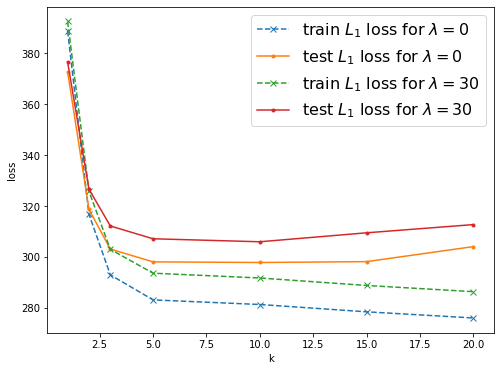

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(8, 6),
                         gridspec_kw={'wspace':0.2,'hspace':0.3})

for lmda in LAMBDA:
    trnlosses = [train_losses[k][lmda] for k in K]
    tstlosses = [test_losses[k][lmda] for k in K]
    
    
    
    axes.plot(K, trnlosses, 'x--',label=fr'train {LOSSS} loss for $\lambda={lmda}$')
    axes.plot(K, tstlosses, '.-', label=fr'test {LOSSS} loss for $\lambda={lmda}$')
    axes.legend(fontsize=16)
    
    axes.set_xlabel('k')
    axes.set_ylabel('loss')
    
plt.show()

## 1.c. part 2

Above we see the functions fitted for different values of $k$ for 2 values of $\lambda$.

From the visualization of the functions, the $\lambda=30$ case does not seem to have much effect on the learned function (even for $k=20$) as both functions visually look wiggly and overfitting to the dataset.

However, looking at the loss vs. $k$ plot above, we see that the test loss without regularization, seems to increase sharply a bit after $k=15$ (orange solid curve), however in case of regularization, the curve seems to more slowly increasing, so the overfitting looks less severe here. 

Note that the loss values for the regularized case are typically higher than the unregularized case because of the added weight penalty to the $L_1$ loss.

In [27]:
# save for later
trnlosses_unnormalized = trnlosses
tstlosses_unnormalized = tstlosses

In [29]:
tstlosses_unnormalized

[376.6373115189948,
 326.59660043380796,
 312.13709798586484,
 307.10481112971206,
 305.9276429339541,
 309.45369921368456,
 312.68737174582037]

## Exercise 1. d part 1 (Normalized basis)

The complexity of a basis function $f(x)$ is defined as $\Omega(f) = \int_{0}^{1} |f'(x)|^2dx \in \mathbb{R}$. 


$\phi_{2\ell-1} = \cos 2\pi\ell x $:
$$
\begin{align}
\Omega(\phi_{2\ell-1}) &= \int_{0}^{1} |\phi_{2\ell-1}'(x)| dx \\
&= \int_{0}^{1} |-2\pi\ell\sin 2\pi\ell x| dx \\
&= 4\pi^2\ell^2\int_{0}^{1} \sin^2 2\pi\ell x dx \\
&= 2\pi^2\ell^2\int_{0}^{1} 2 \sin^2 2\pi\ell x dx \\
&= 2\pi^2\ell^2\int_{0}^{1} (1 - \cos 4\pi\ell x) dx \\
&= 2\pi^2\ell^2 (1 - 0) \\
&= 2\pi^2\ell^2\\
\end{align}
$$

Similarly for $\phi_{2\ell} = \sin 2\pi\ell x $:
$$
\begin{align}
\Omega(\phi_{2\ell}) &= 4\pi^2\ell^2\int_{0}^{1} \cos^2 2\pi\ell x dx \\
&= 2\pi^2\ell^2\int_{0}^{1} 2 \cos^2 2\pi\ell x dx \\
&= 2\pi^2\ell^2\int_{0}^{1} (1 + \cos 4\pi\ell x) dx \\
&= 2\pi^2\ell^2 (1 + 0) \\
&= 2\pi^2\ell^2\\
\end{align}
$$

Hence the functions $\Psi = \{ \psi_i \}_{i \in \mathbb{N}^+}$ all have the same
complexity value of $2\pi^2\ell^2$.

## 1. d part 2

In [31]:
def psi0(x):
    return phi0(x)

def psi_2l_minus_1(x, l):
    return phi_2l_minus_1(x,l) / np.sqrt(2 * np.pi**2 * l**2)

def psi_2l(x, l):
    return phi_2l(x,l) / np.sqrt(2 * np.pi**2 * l**2)

def FourierBasisNormalized(X, k):
        # l runs from 1,2,...,k
    features = [psi0(X)]
    for l in range(1,k+1):
        features.append(psi_2l_minus_1(X, l))
        features.append(psi_2l(X, l))
    return np.column_stack(features)

In [32]:
LOSSS = 'L1'

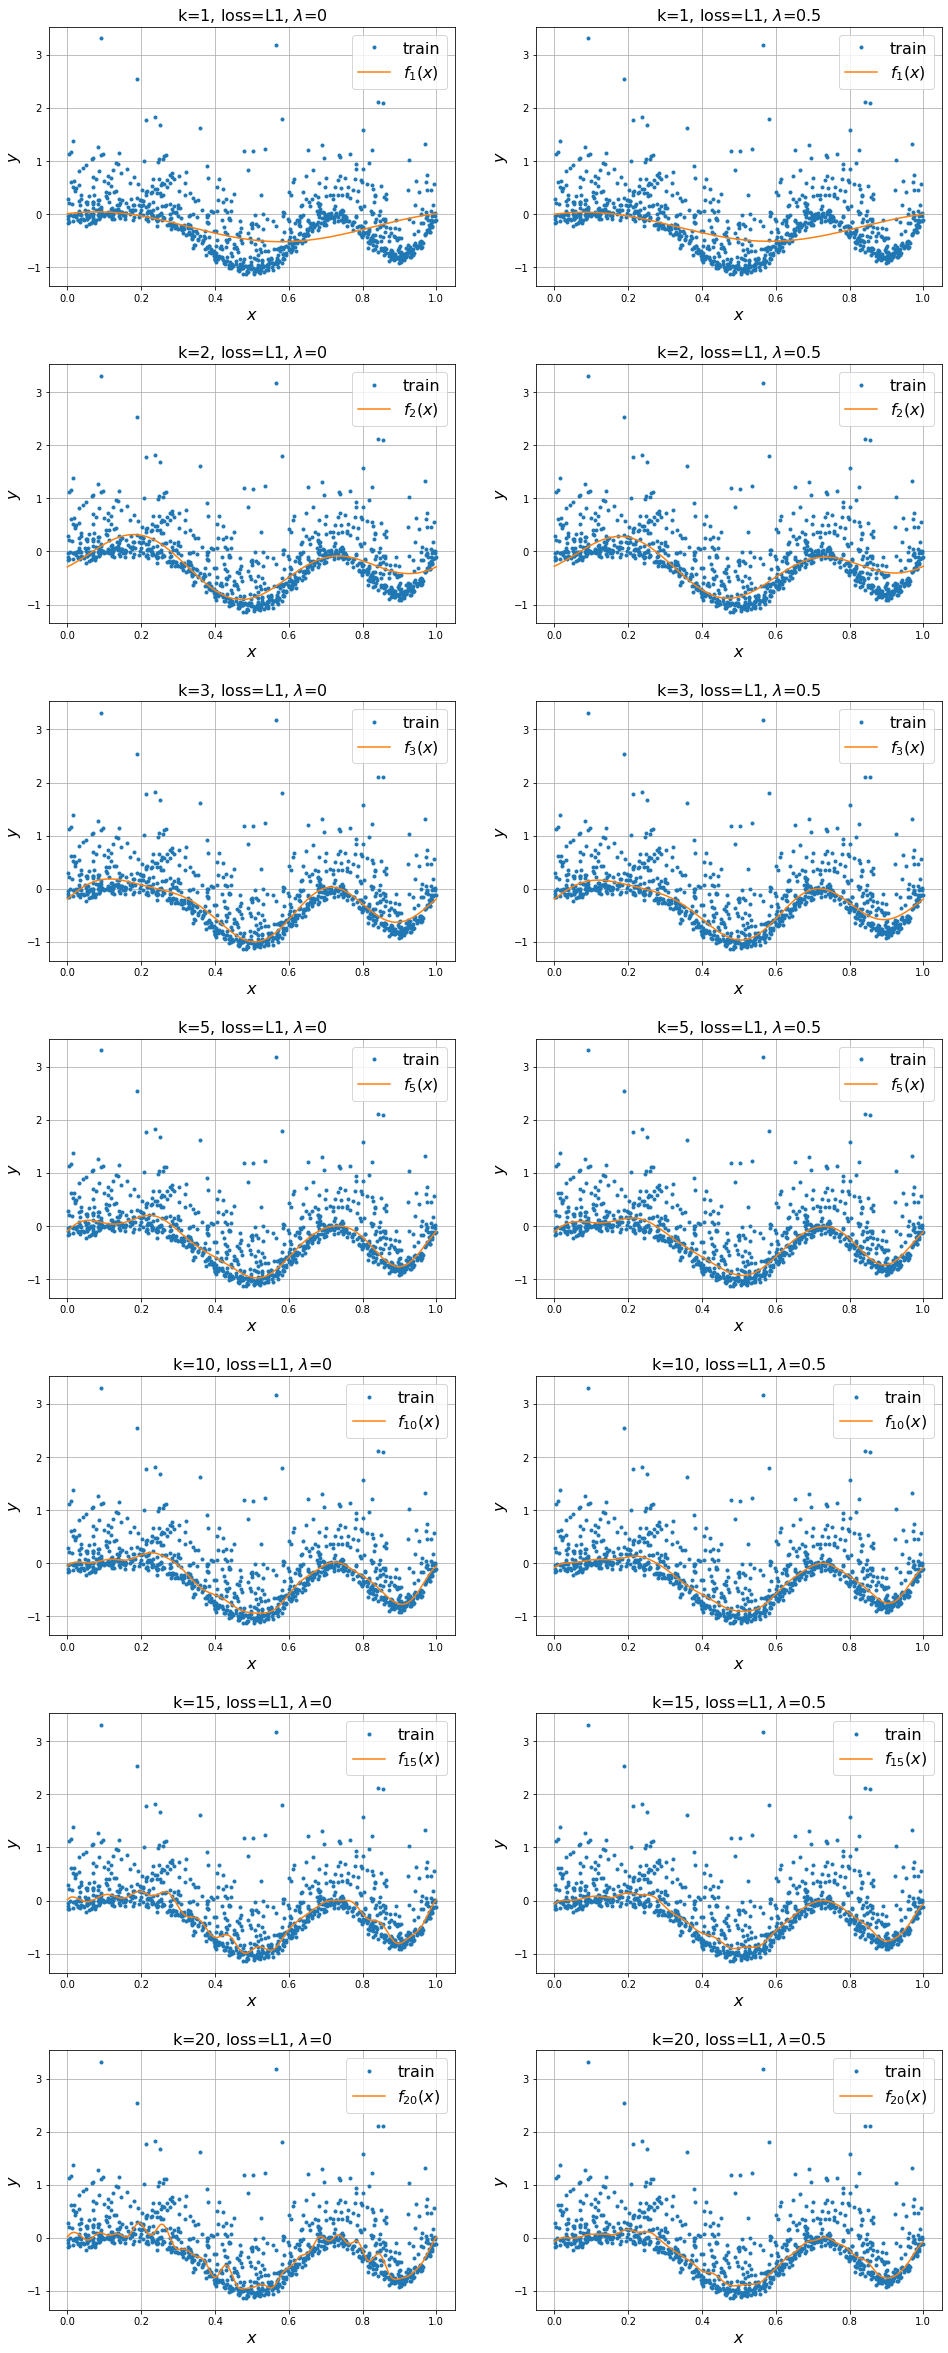

In [33]:
K = [1,2,3,5,10,15,20]
LAMBDA = [0, 0.5]#, 30]#, 100]

nrows = len(K)
ncols = len(LAMBDA)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=(8*ncols, 6*nrows),
                         gridspec_kw={'wspace':0.2,'hspace':0.3})
train_losses = {}
test_losses = {}


for i, k in enumerate(K):
    train_losses[k] = {}
    test_losses[k] = {}
    for j, lmda in enumerate(LAMBDA):
        
        # print(f'k: {k}, lmda: {lmda}')
        x = np.linspace(0, 1, 1000)
        w = L1LossRegression(X=FourierBasisNormalized(Xtrain, k), Y=Ytrain, lmbd_reg=lmda)
        # w = RidgeRegression(Designmatrix=Basis(Xtrain, k), Y=Ytrain, Lambda=lmda)
        # print(w)
        # print(w.shape)
        y_pred = FourierBasisNormalized(x, k) @ w
        
        train_losses[k][lmda] = L1loss(w, FourierBasisNormalized(Xtrain,k), Ytrain, lmda)
        test_losses[k][lmda] = L1loss(w, FourierBasisNormalized(Xtest,k), Ytest, lmda)
        
        ax = axes[i, j]
        ax.plot(Xtrain, Ytrain, '.', label='train')
        ax.plot(x, y_pred, label=fr'$f_{{{k}}}(x)$')
        # plt.plot(Xtest, Ytest, 'x', alpha=0.3, label='test')
        ax.set_xlabel(r'$x$', fontsize=16)
        ax.set_ylabel(r'$y$', fontsize=16)
        ax.grid()
        ax.legend(fontsize=16)
        ax.set_title(fr'k={k}, loss={LOSSS}, $\lambda$={lmda}', fontsize=16)

plt.show()

In [37]:
# fig, axes = plt.subplots(nrows=1, ncols=2,
#                          figsize=(8*2, 6),
#                          gridspec_kw={'wspace':0.2,'hspace':0.3})

# for i, lmda in enumerate(LAMBDA):
#     trnlosses = [train_losses[k][lmda] for k in K]
#     tstlosses = [test_losses[k][lmda] for k in K]
    
#     axes[i].plot(K, trnlosses, '.-', label='train loss')
#     axes[i].plot(K, tstlosses, '.-', label='test loss')
#     axes[i].legend(fontsize=16)
#     axes[i].set_title(fr"$\lambda$={lmda}", fontsize=16)
#     axes[i].set_ylim(260, 420)
    
# plt.show()

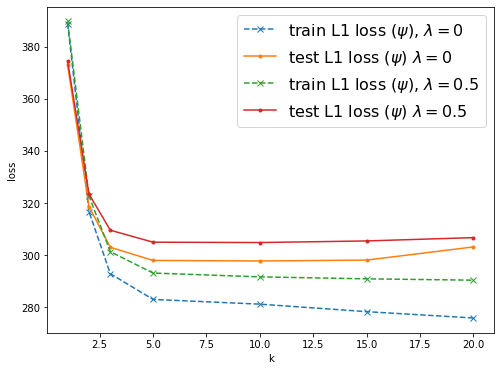

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(8, 6),
                         gridspec_kw={'wspace':0.2,'hspace':0.3})

for lmda in LAMBDA:
    trnlosses = [train_losses[k][lmda] for k in K]
    tstlosses = [test_losses[k][lmda] for k in K]
    
    
    
    axes.plot(K, trnlosses, 'x--',label=fr'train {LOSSS} loss ($\psi$), $\lambda={lmda}$')
    axes.plot(K, tstlosses, '.-', label=fr'test {LOSSS} loss ($\psi$) $\lambda={lmda}$')
    axes.legend(fontsize=16)
    
    axes.set_xlabel('k')
    axes.set_ylabel('loss')
    
plt.show()

## 1. d part 3

So above we see the function visualizations and loss plots with normalized bases $\Psi$ instead of the unnormalized basis $\Phi$.

In this case we clearly see for the $k=20$ and $\lambda=0.5$ case that the wigglyness of the function is reduced than the $\lambda=0$ case, so the effect of regularization is more clearly observed in case of normalized basis functions than the unnormalized ones earlier.

Also the loss plot shows similar trend, i.e., after $k=15$, the unregularized test loss seems to increase sharply (overfitting), and the regularized loss seems more stable (so less overfitting).

## Ridge Regression with normalized basis

In [39]:
def L2loss(w, x, y, lmbd):
    return ((x@w - y)**2).sum() + lmbd * (w**2).sum()

LOSSS='L2'

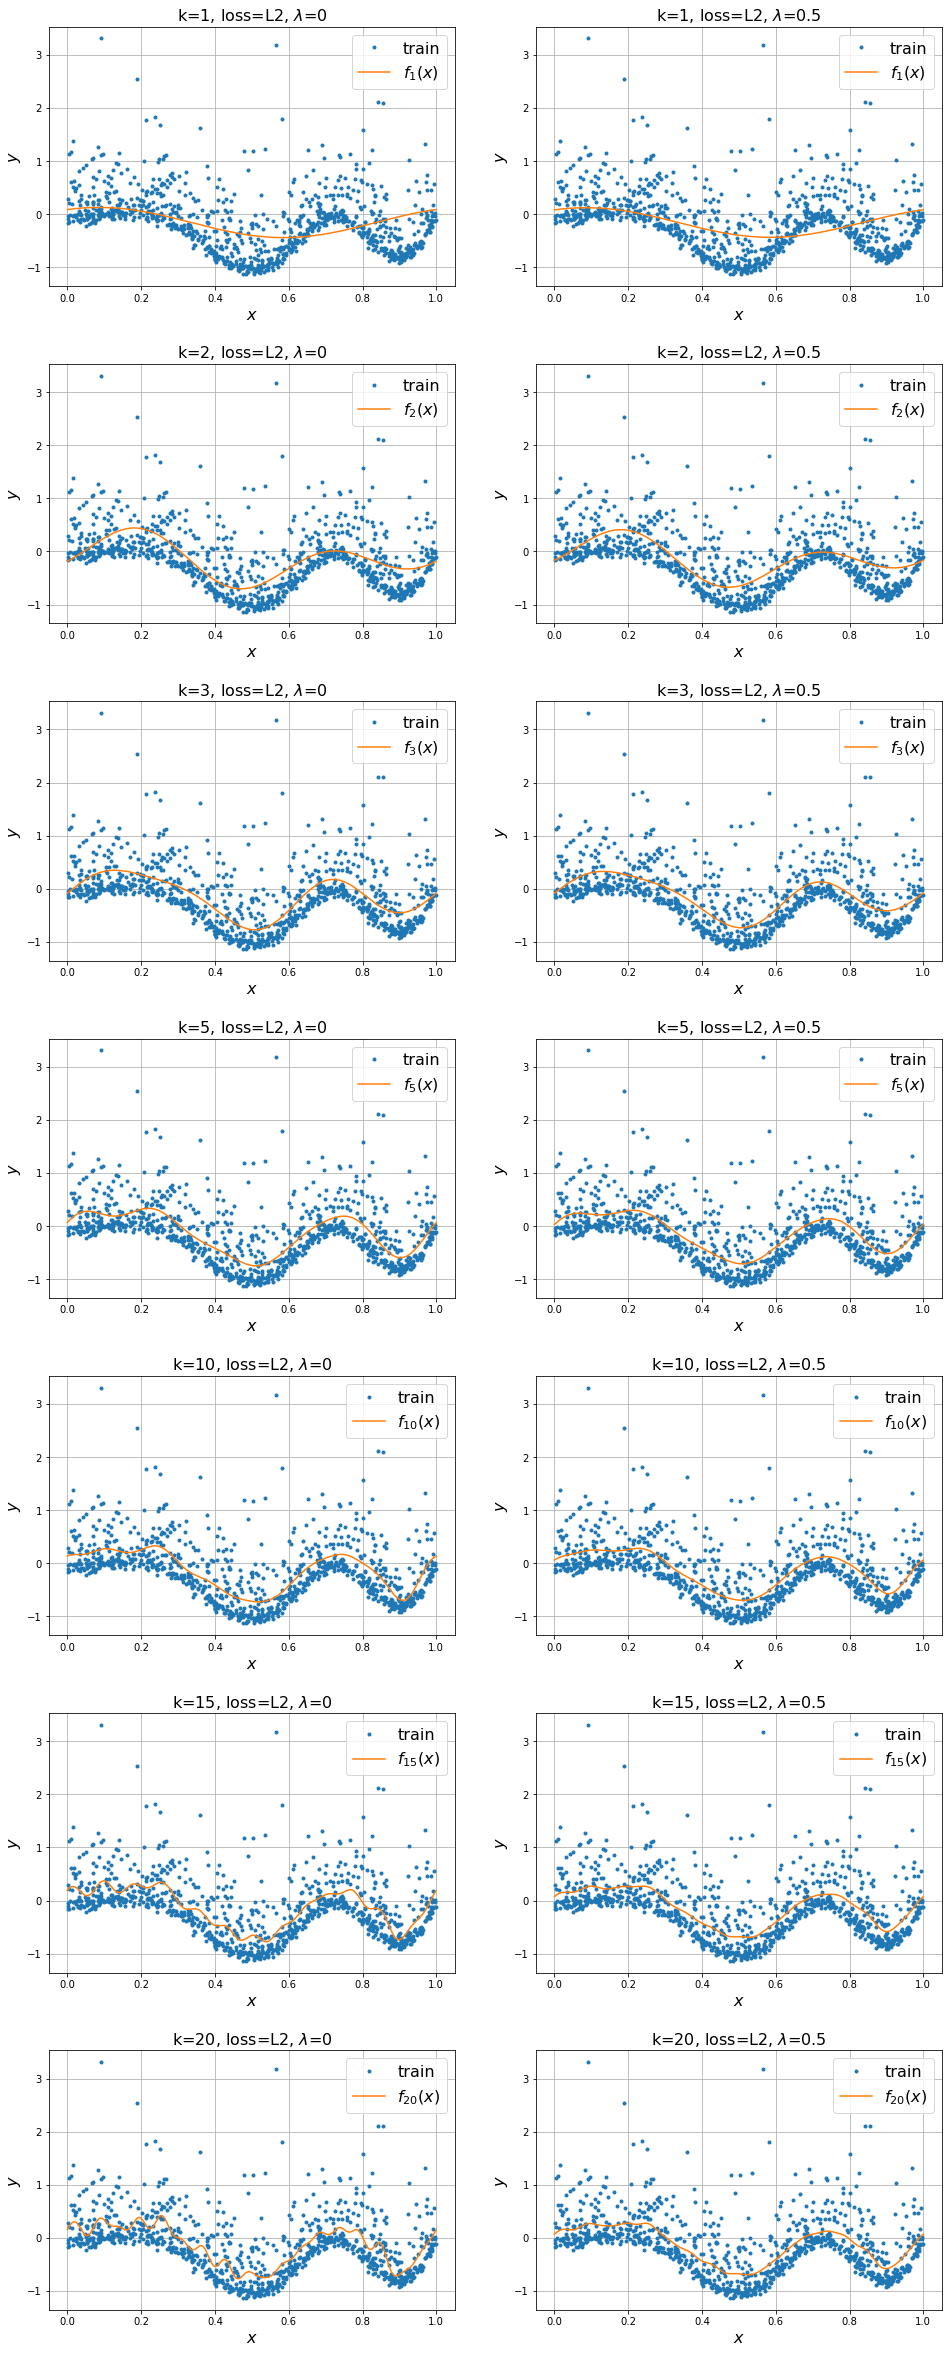

In [40]:
K = [1,2,3,5,10,15,20]
LAMBDA = [0, 0.5]#, 30]#, 100]

nrows = len(K)
ncols = len(LAMBDA)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=(8*ncols, 6*nrows),
                         gridspec_kw={'wspace':0.2,'hspace':0.3})
train_losses = {}
test_losses = {}


for i, k in enumerate(K):
    train_losses[k] = {}
    test_losses[k] = {}
    for j, lmda in enumerate(LAMBDA):
        
        # print(f'k: {k}, lmda: {lmda}')
        x = np.linspace(0, 1, 1000)
        # w = L1LossRegression(X=FourierBasisNormalized(Xtrain, k), Y=Ytrain, lmbd_reg=lmda)
        w = RidgeRegression(Designmatrix=FourierBasisNormalized(Xtrain, k), Y=Ytrain, Lambda=lmda)
        # print(w)
        # print(w.shape)
        y_pred = FourierBasisNormalized(x, k) @ w
        
        train_losses[k][lmda] = L2loss(w, FourierBasisNormalized(Xtrain,k), Ytrain, lmda)
        test_losses[k][lmda] = L2loss(w, FourierBasisNormalized(Xtest,k), Ytest, lmda)
        
        ax = axes[i, j]
        ax.plot(Xtrain, Ytrain, '.', label='train')
        ax.plot(x, y_pred, label=fr'$f_{{{k}}}(x)$')
        # plt.plot(Xtest, Ytest, 'x', alpha=0.3, label='test')
        ax.set_xlabel(r'$x$', fontsize=16)
        ax.set_ylabel(r'$y$', fontsize=16)
        ax.grid()
        ax.legend(fontsize=16)
        ax.set_title(fr'k={k}, loss={LOSSS}, $\lambda$={lmda}', fontsize=16)

plt.show()

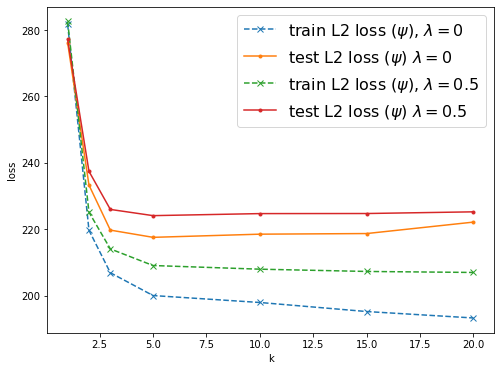

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(8, 6),
                         gridspec_kw={'wspace':0.2,'hspace':0.3})

for lmda in LAMBDA:
    trnlosses = [train_losses[k][lmda] for k in K]
    tstlosses = [test_losses[k][lmda] for k in K]
    
    
    
    axes.plot(K, trnlosses, 'x--',label=fr'train {LOSSS} loss ($\psi$), $\lambda={lmda}$')
    axes.plot(K, tstlosses, '.-', label=fr'test {LOSSS} loss ($\psi$) $\lambda={lmda}$')
    axes.legend(fontsize=16)
    
    axes.set_xlabel('k')
    axes.set_ylabel('loss')
    
plt.show()

So we observe similar behaviour of smoothened functions and overfitting on using **ridge regression** instead of the $L_1$ loss with the regularization.

## Exercise 1. e

Given $f_w(x) = \langle w, \Psi(x) \rangle$ and the modified problem:
$$
w^k = \arg \min_{w \in \mathbb{R^{2k}}} \frac{1}{n} \sum_{i=1}^{n} (Y_i - f_w(X_i))^2 + \lambda \; \Omega(f_w)
$$

In this case simplifying $\Omega(f_w)$, we get:

$$
\begin{align}
\Omega(f_w) &= \int_{0}^{1} |f_w'(x)|^2 dx \\
&= \int_{0}^{1} |\frac{\partial} {\partial x} f_w(x)|^2 dx \\
&= \int_{0}^{1} |\frac{\partial} {\partial x} w^T \psi(x)|^2 dx \\
&= \int_{0}^{1} ||w||^2 |\frac{\partial} {\partial x} \frac{\phi(x)}{\sqrt{\Omega(\phi)}}|^2 dx \\
&= ||w||^2 \int_{0}^{1}  |\frac{\phi'(x)}{\sqrt{\Omega(\phi)}}|^2 dx \\
&= ||w||^2 \int_{0}^{1} \frac{1}{\Omega(\phi)}  |\phi'(x)|^2 dx \\
&= ||w||^2 \frac{1}{\Omega(\phi)} \int_{0}^{1} |\phi'(x)|^2 dx \\
&= ||w||^2 \frac{1}{\Omega(\phi)} \Omega(\phi) \\
&= ||w||^2
\end{align}
$$

Since earlier we derived $\Omega(f) = \int_{0}^{1} |f'(x)|^2dx$, and hence without the constant function $\psi_0(x)$, the above optimization problem is same as ridge regression.

## Exercise 2 -- LASSO

- $||y-x||^2$ is strictly convex function for y (hessian I p.d), hence unique minimizer
- projection onto orthant: $y_i = max\{0, x_i\}$

In [42]:
lmbd = 10
data_new = np.load('multidim_data.npy', allow_pickle=True).item()
X, Y = data_new['Xtrain'], data_new['Ytrain']
Xval, Yval = data_new['Xtest'], data_new['Ytest']

EX, StdX = X.mean(0), X.std(0)

X = (X - EX) / StdX
Xval = (Xval - EX) / StdX

X = np.c_[np.ones((X.shape[0],1)), X]
Xval = np.c_[np.ones((Xval.shape[0],1)), Xval]

In [43]:
X.shape, Y.shape, Xval.shape, Yval.shape

((1500, 101), (1500, 1), (402, 101), (402, 1))

In [44]:
def L2Loss(x, y):
    return (x - y) ** 2

def LassoObjective(wplus, wminus, Phi, Y, lmbd):
    ''' evaluates the objective function at (wplus, wminus)
    L2 loss + L1 regularization
    '''
    w = wplus - wminus
    return ((Phi @ w - Y) ** 2).mean(
        ) + lmbd * np.abs(w).sum()

In [53]:
def GradLassoObjective(wplus, wminus, Phi, Y, lmbd):
    ''' computes the gradients of the objective function
    at (wplus, wminus)
    gradwplus: gradient wrt wplus
    gradwminus: gradient wrt minus

    FILL IN
    '''

    #gradwplus = np.zeros(wplus.shape)    # TODO 
    #gradwminus = np.zeros(wminus.shape)  # TODO
    
    n = Phi.shape[0]
    gradwplus = (2/n) * ((Phi.T@Phi) @ (wplus-wminus) - Phi.T@Y) + lmbd*np.sign(wplus)
    gradwminus = (2/n) * ((Phi.T@Phi) @ (wminus-wplus) + Phi.T@Y) + lmbd*np.sign(wminus)
    
    return gradwplus, gradwminus

def ProjectionPositiveOrthant(x):
    ''' returns the projection of x onto the positive orthant

    FILL IN
    '''
    y = x # TODO 
    negidx = y < 0
    y[negidx] = 0
    return y

def getStepSize(wplus, wminus, Phi, Y, lmbd, gradwplus,
                gradwminus, loss):
    ''' performs one step of projected gradient descent (i.e.
    compute next iterate) with step size selection via
    backtracking line search

    input
    loss: objective function at current iterate (wplus, wminus)

    output
    wplusnew, wminusnew: next iterates wplus_{t+1}, wminus_{t+1}
    lossnew: objective function at the new iterate
    
    FILL IN
    '''
    alpha, beta, sigma = 1., .001, .1
    wplusnew, wminusnew = wplus.copy(), wminus.copy()
    lossnew = np.float64('Inf') # make sure to enter the loop

    # choose the step size alpha with backtracking line search
    while lossnew > loss + sigma * ((gradwplus * (
        wplusnew - wplus)).sum() + (gradwminus * (
        wminusnew - wminus)).sum()):
        # get new step size to test
        alpha *= beta

        # projected gradient step for wplus and wminus with step size alpha
        # i.e. compute x_{t+1} as in the text
        # FILL IN
        # print('fill in with projected gradient step')
        wplusnew = ProjectionPositiveOrthant(wplus - alpha * gradwplus)    # TODO 
        wminusnew = ProjectionPositiveOrthant(wminus - alpha * gradwminus)  # TODO

        # compute new value of the objective
        lossnew = LassoObjective(wplusnew, wminusnew, Phi, Y, lmbd)

    return wplusnew, wminusnew, lossnew

In [54]:
ProjectionPositiveOrthant(np.random.randn(10))

array([0.46472769, 0.76267009, 0.05160864, 0.49303708, 0.        ,
       2.36262272, 0.        , 1.27026993, 0.06354957, 1.26238757])

In [55]:
def Lasso(Phi, Y, lmbd):
    ''' compute weight of linear regression with Lasso

    Phi: deisgn matrix n x d
    Y: true values n x 1
    lmbd: weight of regularization

    output: weights of linear regression d x 1
    '''
    # initialize wplus, wminus
    wplus = np.random.rand(Phi.shape[1], 1)
    wminus = np.random.rand(*wplus.shape)
    loss = LassoObjective(wplus, wminus, Phi, Y, lmbd)

    counter = 1
    while counter > 0:
        # compute gradients wrt wplus and wminus
        gradwplus, gradwminus = GradLassoObjective(
            wplus, wminus, Phi, Y, lmbd)

        # compute new iterates
        wplus, wminus, loss = getStepSize(wplus,
            wminus, Phi, Y, lmbd, gradwplus, gradwminus, loss)

        if (counter % 5_000) == 0:
            # check if stopping criterion is met
            wnew = wplus - wminus
            ind = wnew != 0.
            indz = wnew == 0.
            r = 2 / Phi.shape[0] * (Phi.T @ (Phi @ wnew - Y))
            stop = np.abs(r[ind] + lmbd * np.sign(wnew[ind]
                )).sum() + (np.abs(r[indz]) - lmbd * np.ones_like(
                r[indz])).clip(0.).sum()
            print('iter={} current objective={:.3f} nonzero weights={}'.format(
                counter, loss, ind.sum()) +\
                ' stop={:.5f}'.format(stop / Phi.shape[0]))
            if np.abs(stop) / Phi.shape[0] < 1e-5:
                break
        counter += 1

    #print((wplus == 0).sum(), (wminus == 0).sum())

    return wplus - wminus

In [56]:
t_init = time.time()
w = Lasso(X, Y, lmbd)
print('runtime: {:.3f} s'.format(time.time() - t_init))

iter=5000 current objective=141825.436 nonzero weights=52 stop=0.04564
iter=10000 current objective=141557.092 nonzero weights=47 stop=0.01792
iter=15000 current objective=141484.857 nonzero weights=46 stop=0.01132
iter=20000 current objective=141457.038 nonzero weights=44 stop=0.00682
iter=25000 current objective=141441.792 nonzero weights=44 stop=0.00552
iter=30000 current objective=141429.817 nonzero weights=44 stop=0.00470
iter=35000 current objective=141419.900 nonzero weights=43 stop=0.00386
iter=40000 current objective=141411.580 nonzero weights=43 stop=0.00341
iter=45000 current objective=141404.350 nonzero weights=43 stop=0.00308
iter=50000 current objective=141397.988 nonzero weights=43 stop=0.00280
iter=55000 current objective=141392.336 nonzero weights=43 stop=0.00258
iter=60000 current objective=141387.272 nonzero weights=43 stop=0.00240
iter=65000 current objective=141382.776 nonzero weights=42 stop=0.00213
iter=70000 current objective=141378.741 nonzero weights=42 stop=0

In [61]:
w[:, 0]

array([ 5.72504820e+02,  0.00000000e+00,  0.00000000e+00,  1.09490077e+02,
       -3.11345853e+01, -4.88992248e+00,  0.00000000e+00,  0.00000000e+00,
       -1.09249235e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.24601806e+01,  0.00000000e+00, -1.67280200e+01,  0.00000000e+00,
       -3.63109720e+01,  0.00000000e+00,  0.00000000e+00, -3.23016957e+01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.95579741e+00,
        2.52666589e-02,  1.39223485e+01,  8.40782202e+00,  0.00000000e+00,
       -1.60607029e+01, -1.62015616e+01,  0.00000000e+00, -6.35629570e+00,
        0.00000000e+00,  0.00000000e+00, -1.90167107e+01, -5.43421433e+00,
        0.00000000e+00,  0.00000000e+00,  5.25368406e+01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.35092139e+02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -3.19512469e+01,  0.00000000e+00,  1.15812741e+02, -5.83588862e+00,
        0.00000000e+00, -

training loss: 125093.11209
validation loss: 200280.40565


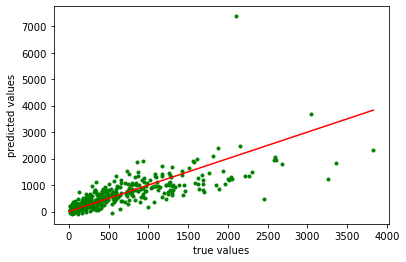

In [62]:
LossTrain = L2Loss(X @ w, Y)
print('training loss: {:.5f}'.format(LossTrain.mean()))
Yvalpred = Xval @ w # TODO, compute predictions
LossVal = L2Loss(Yvalpred, Yval)
print('validation loss: {:.5f}'.format(LossVal.mean()))
plt.plot(Yval, Yvalpred, '.g')
plt.plot([0, np.amax(Yval)], [0, np.amax(Yval)], '-r')
ax = plt.gca()
ax.set_xlabel('true values')
ax.set_ylabel('predicted values')
plt.show()

training loss: 125093.05681
validation loss: 200281.10508


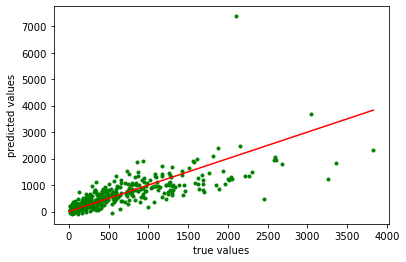

In [12]:
LossTrain = L2Loss(X @ w, Y)
print('training loss: {:.5f}'.format(LossTrain.mean()))
Yvalpred = Xval @ w # TODO, compute predictions
LossVal = L2Loss(Yvalpred, Yval)
print('validation loss: {:.5f}'.format(LossVal.mean()))
plt.plot(Yval, Yvalpred, '.g')
plt.plot([0, np.amax(Yval)], [0, np.amax(Yval)], '-r')
ax = plt.gca()
ax.set_xlabel('true values')
ax.set_ylabel('predicted values')
plt.show()